In [30]:
import os
import sys
os.environ["JAVA_HOME"] = "change location"
os.environ["JDK_JAVA_OPTIONS"] = "-Djava.security.manager=allow"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [31]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col ,count, desc
from pyspark.sql.functions import avg
from pyspark.sql.functions import concat, lit
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
spark = SparkSession.builder \
    .appName("FlightDelayPrediction") \
    .config("spark.driver.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")


sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


# 1. Data Loading and Cleaning


In [48]:
df = spark.read.csv("Flight_delay.csv", header=True, inferSchema=True)
print(f"Original row count: {df.count()}")

numeric_cols_to_cast = [
    "ArrDelay", "DepDelay", "Distance", "DayOfWeek", "Month", "Day",
    "TaxiIn", "TaxiOut", "CarrierDelay", "WeatherDelay", "NASDelay", 
    "SecurityDelay", "LateAircraftDelay", "ActualElapsedTime", 
    "AirTime", "DepTime", "ArrTime", "CRSArrTime", "CRSElapsedTime"
]

df_clean = df.filter((col("Cancelled") == 0) & (col("Diverted") == 0)).drop("Cancelled", "Diverted")
df_clean = df_clean.withColumn("DepHour", (col("DepTime") / 100).cast("int"))

existing_cols = df.columns
cols_to_cast = [c for c in numeric_cols_to_cast if c in existing_cols]

for c in cols_to_cast:
    df_clean = df_clean.withColumn(c, col(c).cast("double"))

df_clean = df_clean.dropna(subset=["ArrDelay", "DepDelay"])
print(f"Row count after cleaning: {df_clean.count()}")

df_clean.cache()


Original row count: 484551
Row count after cleaning: 484551


DataFrame[DayOfWeek: double, Date: string, DepTime: double, ArrTime: double, CRSArrTime: double, UniqueCarrier: string, Airline: string, FlightNum: int, TailNum: string, ActualElapsedTime: double, CRSElapsedTime: double, AirTime: double, ArrDelay: double, DepDelay: double, Origin: string, Org_Airport: string, Dest: string, Dest_Airport: string, Distance: double, TaxiIn: double, TaxiOut: double, CancellationCode: string, CarrierDelay: double, WeatherDelay: double, NASDelay: double, SecurityDelay: double, LateAircraftDelay: double, DepHour: int]

# 2. Basic Statistics


In [34]:
df.show(5)

+---------+----------+-------+-------+----------+-------------+--------------------+---------+-------+-----------------+--------------+-------+--------+--------+------+--------------------+----+--------------------+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|DayOfWeek|      Date|DepTime|ArrTime|CRSArrTime|UniqueCarrier|             Airline|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|         Org_Airport|Dest|        Dest_Airport|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---------+----------+-------+-------+----------+-------------+--------------------+---------+-------+-----------------+--------------+-------+--------+--------+------+--------------------+----+--------------------+--------+------+-------+---------+----------------+--------+------------+------------+--------+----

In [35]:
display_cols = ["ArrDelay", "DepDelay", "Distance", "ActualElapsedTime"]
df_clean.select([c for c in display_cols if c in df_clean.columns]).summary().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|          ArrDelay|          DepDelay|         Distance| ActualElapsedTime|
+-------+------------------+------------------+-----------------+------------------+
|  count|            484551|            484551|           484551|            484551|
|   mean| 60.90776409500754| 57.49808585680351|752.1426887984959|134.81042243231363|
| stddev|56.975420383828165|55.991012368506205|571.6311237228965| 74.07037431845504|
|    min|              15.0|               6.0|             31.0|              15.0|
|    25%|              25.0|              23.0|            331.0|              80.0|
|    50%|              42.0|              40.0|            599.0|             116.0|
|    75%|              76.0|              72.0|            992.0|             168.0|
|    max|            1707.0|            1710.0|           4502.0|             727.0|
+-------+------------------+------------------+-----------------+

# 3. Univariate Analysis
## Distribution of Arrival Delay


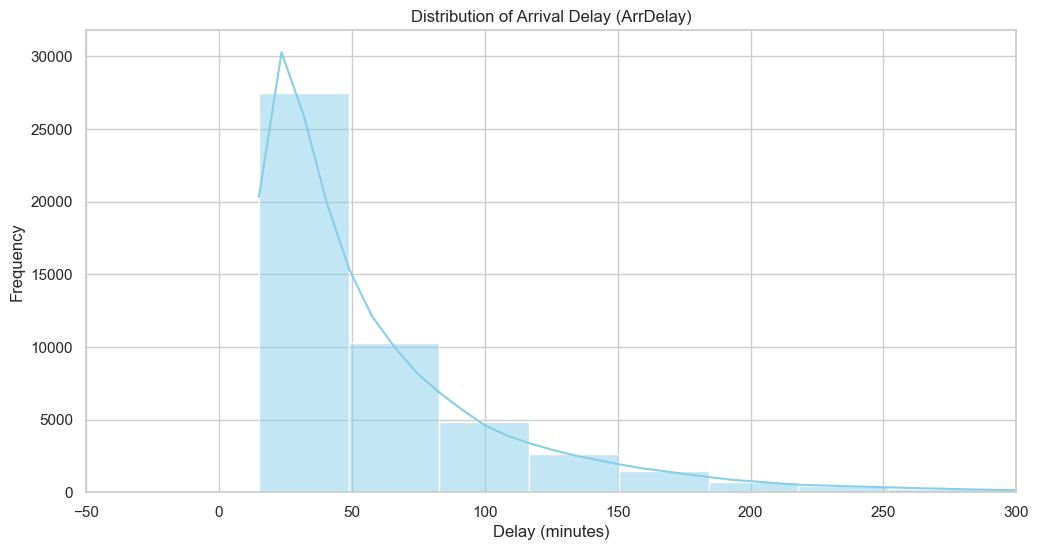

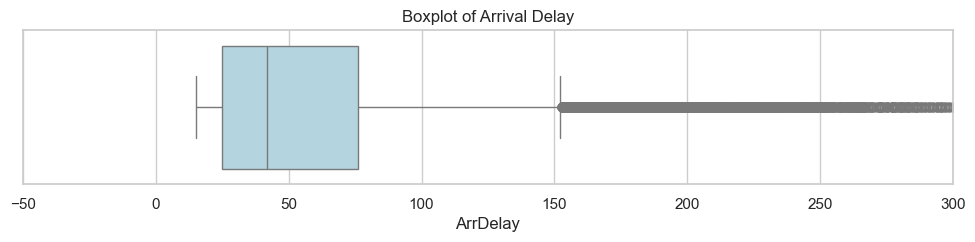

In [36]:
pdf = df_clean.select("ArrDelay").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(pdf["ArrDelay"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Arrival Delay (ArrDelay)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.xlim(-50, 300)
plt.show()

plt.figure(figsize=(12, 2))
sns.boxplot(x=pdf["ArrDelay"], color='lightblue')
plt.title("Boxplot of Arrival Delay")
plt.xlim(-50, 300)
plt.show()


## Distribution of Departure Delay


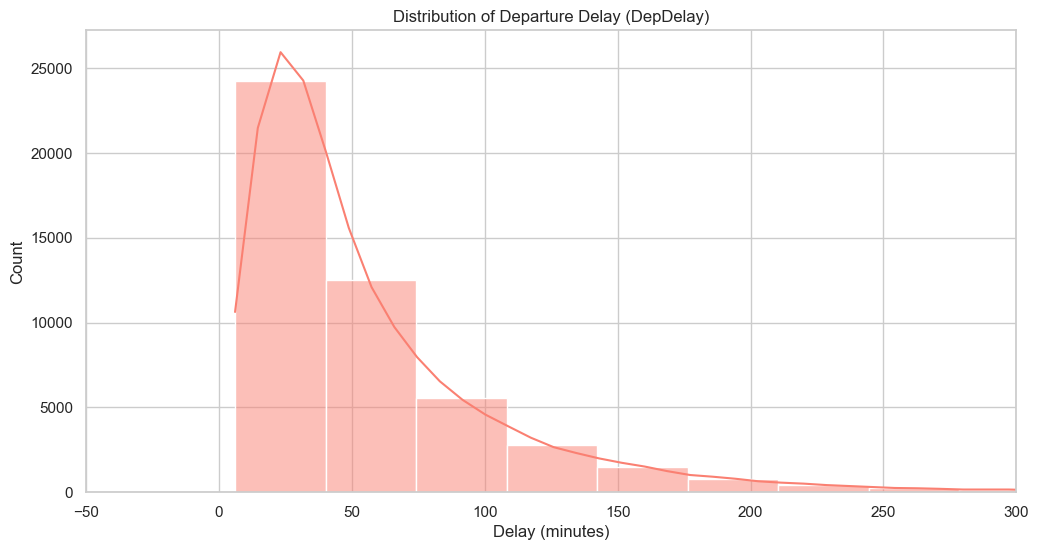

In [37]:
pdf_dep = df_clean.select("DepDelay").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(pdf_dep["DepDelay"], bins=50, kde=True, color='salmon')
plt.title("Distribution of Departure Delay (DepDelay)")
plt.xlabel("Delay (minutes)")
plt.xlim(-50, 300)
plt.show()


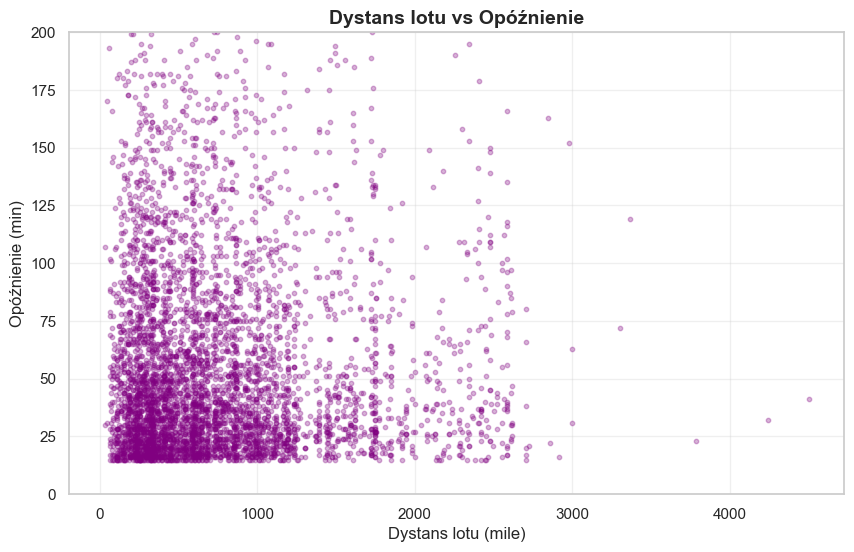

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

total_rows = df_clean.count()
desired_sample_size = min(5000, total_rows)

if total_rows > 0 and desired_sample_size < total_rows:
    fraction_to_sample = desired_sample_size / total_rows
    sample_spark_df = df_clean.sample(False, fraction_to_sample, seed=42)
else:
    sample_spark_df = df_clean

sample_plot = sample_spark_df.limit(desired_sample_size).toPandas()

ax.scatter(sample_plot['Distance'], sample_plot['ArrDelay'],
                   alpha=0.3, s=10, color='purple')
ax.set_xlabel('Dystans lotu (mile)', fontsize=12)
ax.set_ylabel('Opóźnienie (min)', fontsize=12)
ax.set_title('Dystans lotu vs Opóźnienie', fontsize=14, fontweight='bold')
ax.set_ylim(0, 200)
ax.grid(True, alpha=0.3)
plt.show()

# 4. Bivariate Analysis
## Correlation Matrix (All Variables)


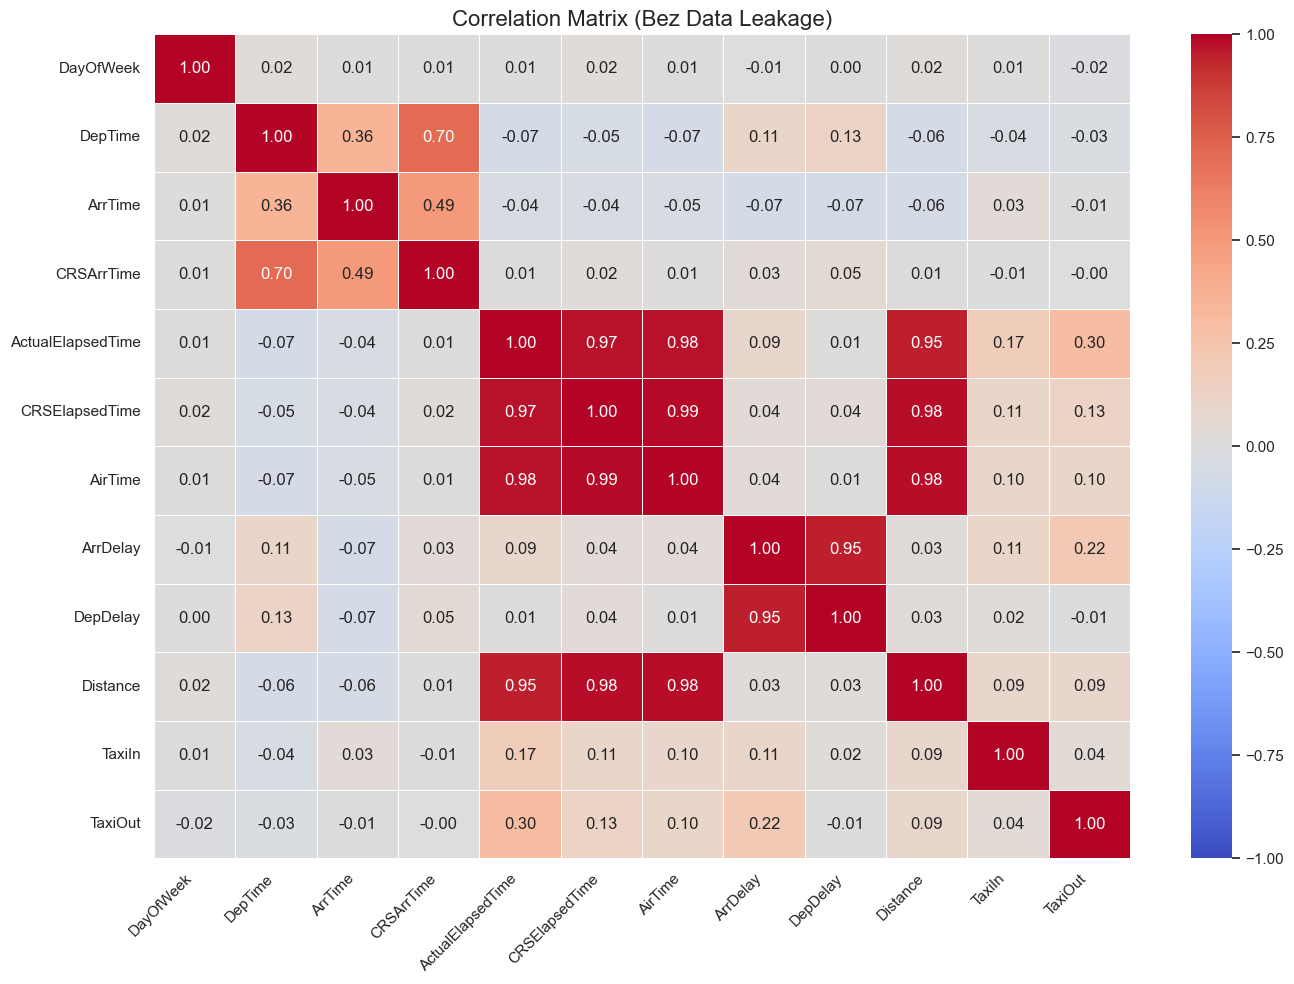

In [39]:
cols_to_drop = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled', 'Diverted', 'CancellationCode', 'FlightNum']

numeric_cols = [f.name for f in df_clean.schema.fields
                if (str(f.dataType).startswith('Integer') or str(f.dataType).startswith('Double'))
                and f.name not in cols_to_drop]

sample_pdf = df_clean.select(numeric_cols).sample(False, 0.2, seed=42).toPandas()
corr_matrix = sample_pdf.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## DepDelay vs ArrDelay


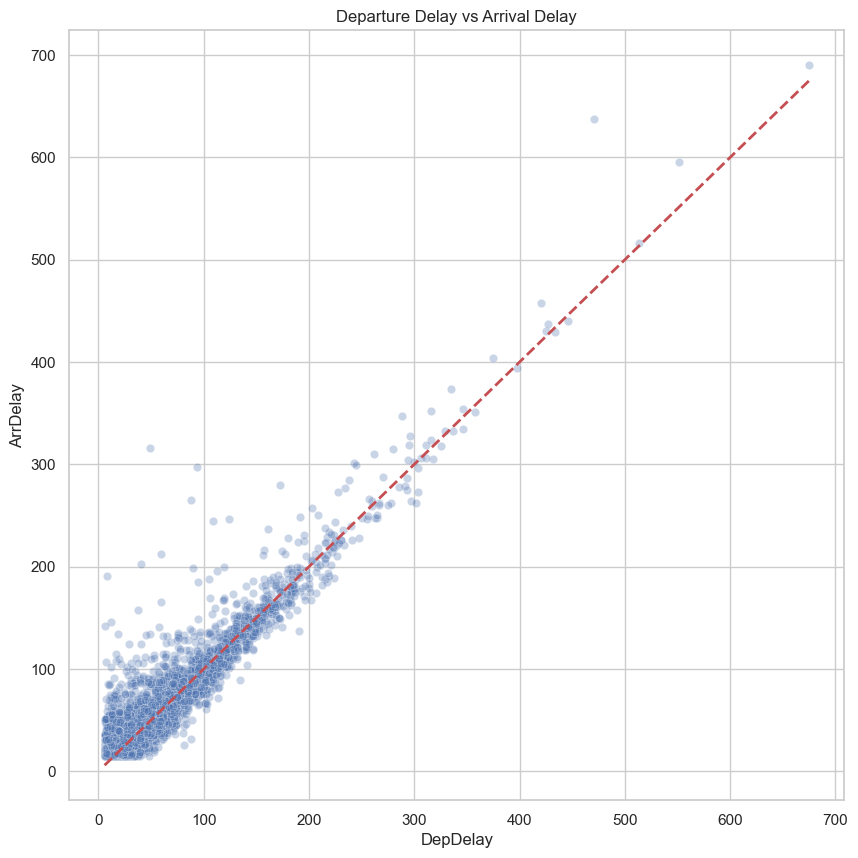

In [40]:
pdf_scatter = df_clean.select("DepDelay", "ArrDelay").sample(False, 0.01, seed=42).toPandas()

plt.figure(figsize=(10, 10))
sns.scatterplot(x="DepDelay", y="ArrDelay", data=pdf_scatter, alpha=0.3)
plt.plot([pdf_scatter["DepDelay"].min(), pdf_scatter["DepDelay"].max()], 
         [pdf_scatter["DepDelay"].min(), pdf_scatter["DepDelay"].max()], 
         'r--', lw=2)
plt.title("Departure Delay vs Arrival Delay")
plt.show()


# 5. Categorical Analysis
## Average Delay by Carrier


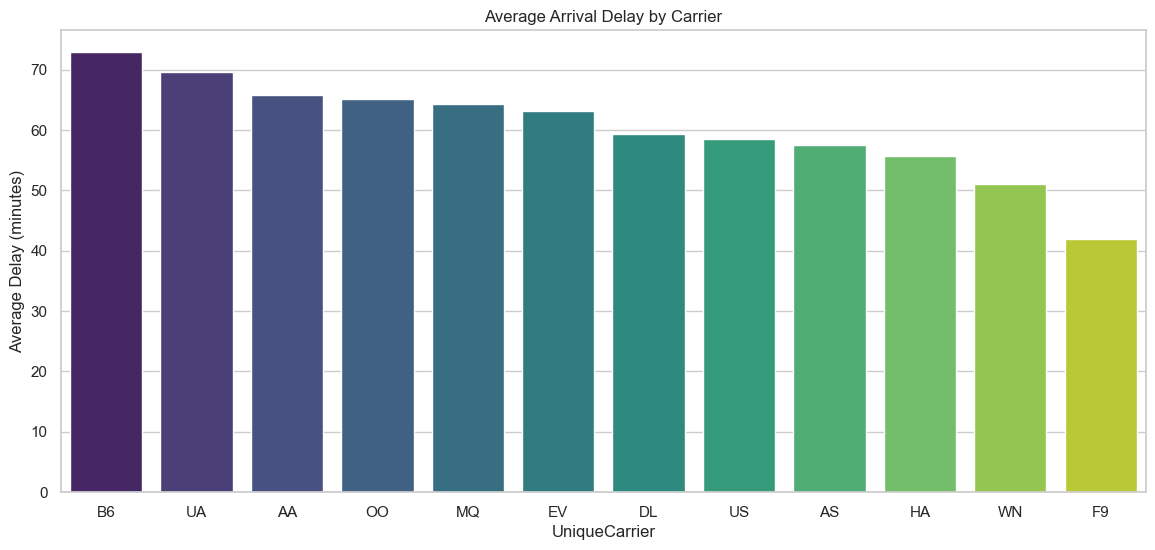

In [41]:
carrier_delay = df_clean.groupBy("UniqueCarrier").agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("AvgDelay", ascending=False).toPandas()

plt.figure(figsize=(14, 6))

sns.barplot(x="UniqueCarrier", y="AvgDelay", data=carrier_delay, palette="viridis", hue="UniqueCarrier", legend=False)

plt.title("Average Arrival Delay by Carrier")
plt.ylabel("Average Delay (minutes)")
plt.show()

# 6. Temporal Analysis
## Average Delay by Hour of Day


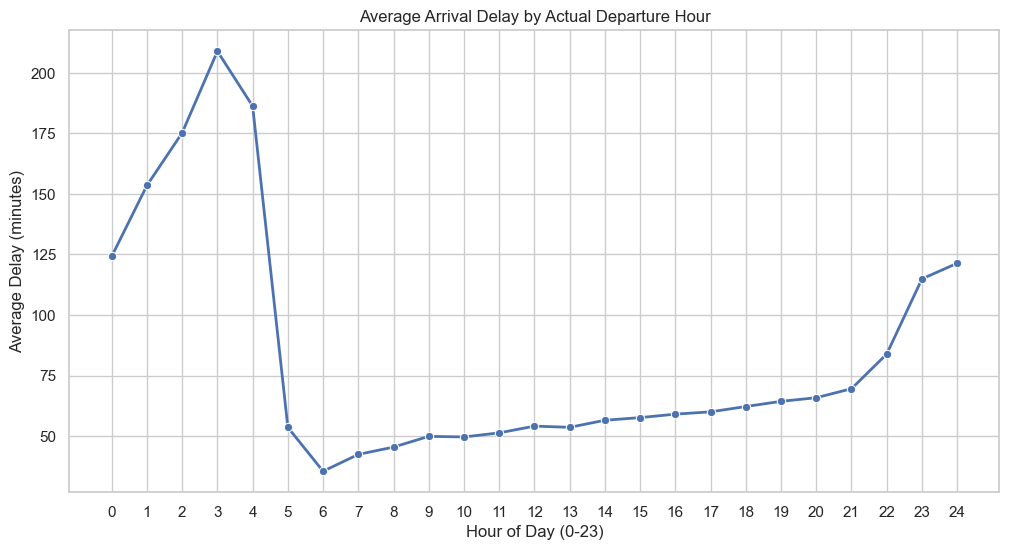

In [42]:
df_hour = df_clean.withColumn("DepHour", (col("DepTime") / 100).cast("integer"))

hour_delay = df_hour.groupBy("DepHour").agg(avg("ArrDelay").alias("AvgDelay"))     .orderBy("DepHour").toPandas()

plt.figure(figsize=(12, 6))
sns.lineplot(x="DepHour", y="AvgDelay", data=hour_delay, marker="o", lw=2)
plt.title("Average Arrival Delay by Actual Departure Hour")
plt.xlabel("Hour of Day (0-23)")
plt.ylabel("Average Delay (minutes)")
plt.xticks(range(0, 25))
plt.grid(True)
plt.show()


## Average Delay by Day of Week


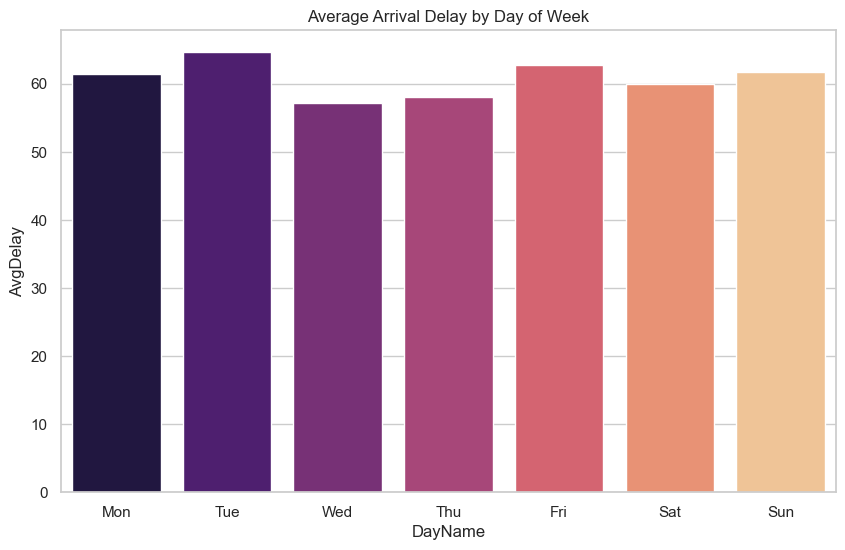

In [43]:
day_delay = df_clean.groupBy("DayOfWeek").agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("DayOfWeek").toPandas()

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
day_delay['DayName'] = day_delay['DayOfWeek'].map(days)

plt.figure(figsize=(10, 6))

sns.barplot(x="DayName", y="AvgDelay", data=day_delay, palette="magma", hue="DayName", legend=False)

plt.title("Average Arrival Delay by Day of Week")
plt.show()

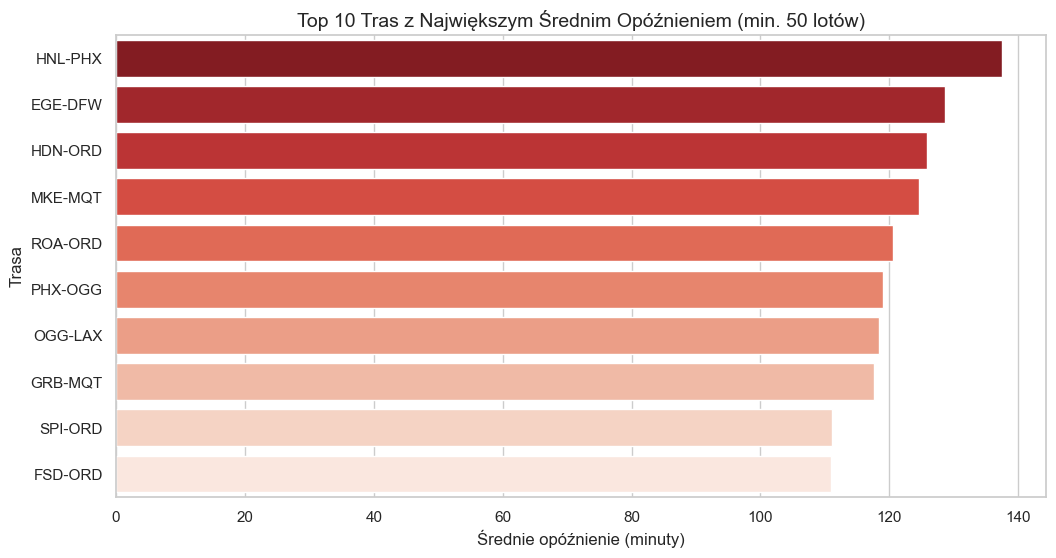

In [44]:
df_routes = df_clean.withColumn("Route", concat(col("Origin"), lit("-"), col("Dest")))

route_stats = df_routes.groupBy("Route").agg(
    avg("ArrDelay").alias("AvgDelay"),
    count("*").alias("FlightCount")
).filter(col("FlightCount") > 50)

top_10_routes = route_stats.orderBy(desc("AvgDelay")).limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="AvgDelay", y="Route", data=top_10_routes, palette="Reds_r", hue="Route", legend=False)

plt.title("Top 10 Tras z Największym Średnim Opóźnieniem (min. 50 lotów)", fontsize=14)
plt.xlabel("Średnie opóźnienie (minuty)")
plt.ylabel("Trasa")
plt.show()

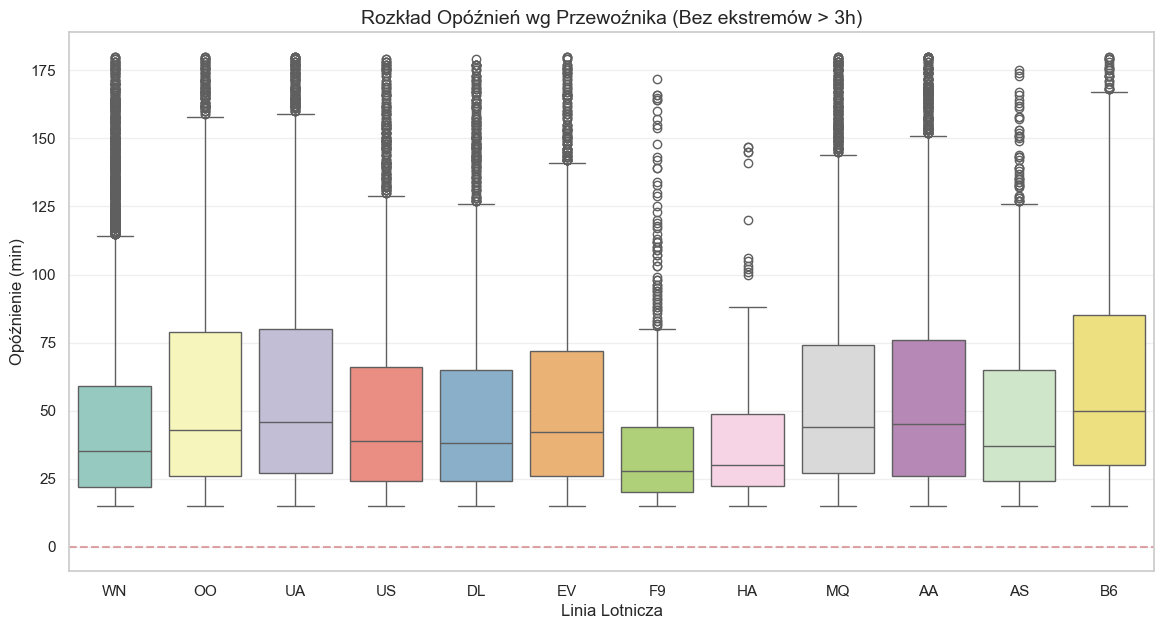

In [46]:
sample_pdf = df_clean.select("UniqueCarrier", "ArrDelay") \
    .sample(False, 0.1, seed=42) \
    .toPandas()

sample_filtered = sample_pdf[sample_pdf['ArrDelay'].between(-30, 180)]

plt.figure(figsize=(14, 7))
sns.boxplot(x="UniqueCarrier", y="ArrDelay", data=sample_filtered, palette="Set3", hue="UniqueCarrier", legend=False)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title("Rozkład Opóźnień wg Przewoźnika", fontsize=14)
plt.xlabel("Linia Lotnicza")
plt.ylabel("Opóźnienie (min)")
plt.grid(True, axis='y', alpha=0.3)
plt.show()

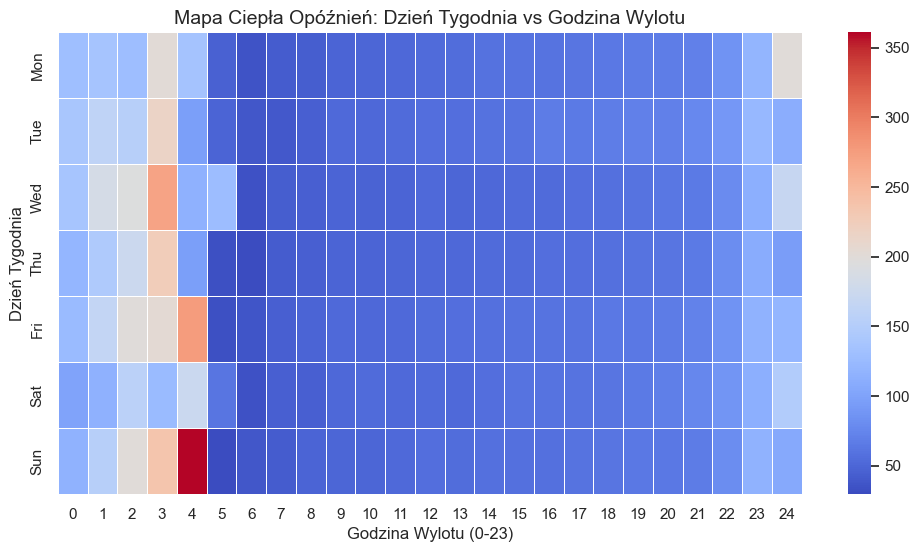

In [49]:
heatmap_data = df_clean.groupBy("DayOfWeek", "DepHour") \
    .agg(avg("ArrDelay").alias("AvgDelay")) \
    .orderBy("DayOfWeek", "DepHour") \
    .toPandas()

heatmap_pivot = heatmap_data.pivot(index="DayOfWeek", columns="DepHour", values="AvgDelay")

days_map = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}
heatmap_pivot.index = heatmap_pivot.index.map(days_map)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="coolwarm", annot=False, fmt=".1f", linewidths=.5)
plt.title("Mapa Ciepła Opóźnień: Dzień Tygodnia vs Godzina Wylotu", fontsize=14)
plt.xlabel("Godzina Wylotu (0-23)")
plt.ylabel("Dzień Tygodnia")
plt.show()

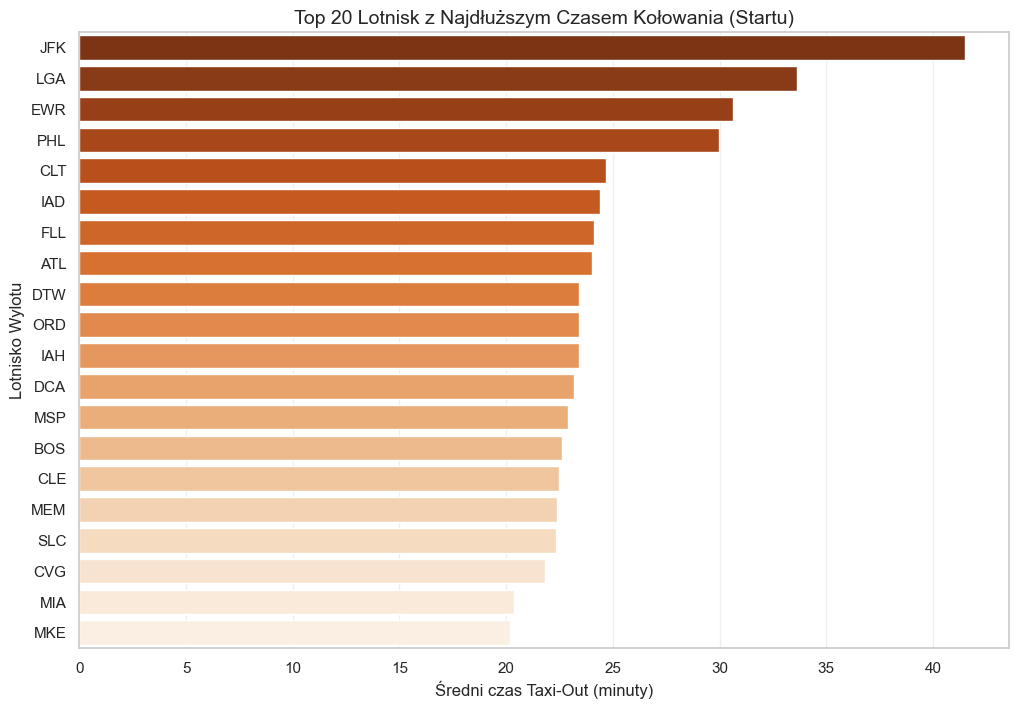

In [50]:
taxi_stats = df_clean.groupBy("Origin") \
    .agg(avg("TaxiOut").alias("AvgTaxiOut"), count("*").alias("FlightCount")) \
    .filter(col("FlightCount") > 1000) \
    .orderBy("AvgTaxiOut", ascending=False) \
    .limit(20) \
    .toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(x="AvgTaxiOut", y="Origin", data=taxi_stats, palette="Oranges_r", hue="Origin", legend=False)
plt.title("Top 20 Lotnisk z Najdłuższym Czasem Kołowania (Startu)", fontsize=14)
plt.xlabel("Średni czas Taxi-Out (minuty)")
plt.ylabel("Lotnisko Wylotu")
plt.grid(axis='x', alpha=0.3)
plt.show()

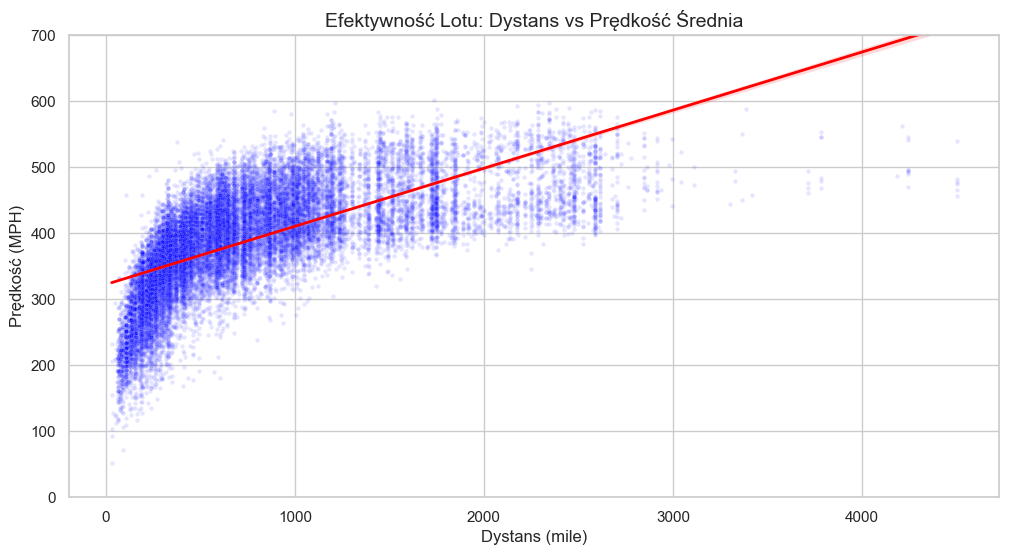

In [51]:
speed_df = df_clean.filter(col("AirTime") > 0) \
    .withColumn("Speed_MPH", col("Distance") / (col("AirTime") / 60)) \
    .select("Distance", "Speed_MPH", "UniqueCarrier") \
    .sample(False, 0.05, seed=42) \
    .toPandas()

plt.figure(figsize=(12, 6))
sns.scatterplot(x="Distance", y="Speed_MPH", data=speed_df, alpha=0.1, color='blue', s=10)

sns.regplot(x="Distance", y="Speed_MPH", data=speed_df, scatter=False, color='red', line_kws={'linewidth':2})

plt.title("Efektywność Lotu: Dystans vs Prędkość Średnia", fontsize=14)
plt.xlabel("Dystans (mile)")
plt.ylabel("Prędkość (MPH)")
plt.ylim(0, 700)
plt.show()

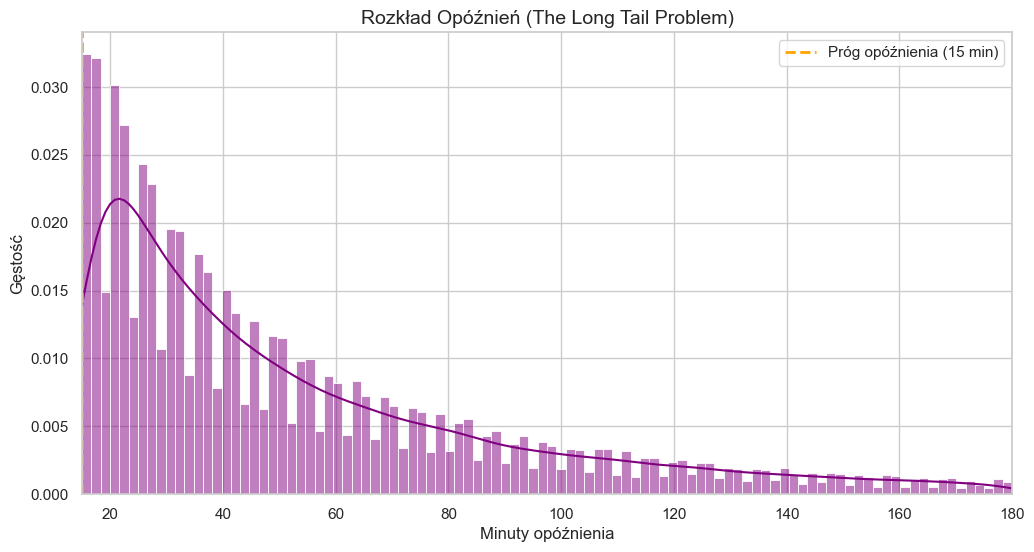

In [55]:
dist_data = df_clean.select("ArrDelay") \
    .filter(col("ArrDelay").between(-60, 180)) \
    .sample(False, 0.1, seed=42) \
    .toPandas()

plt.figure(figsize=(12, 6))

sns.histplot(dist_data['ArrDelay'], bins=100, kde=True, color='purple', stat="density")

plt.axvline(x=15, color='orange', linestyle='--', linewidth=2, label='Próg opóźnienia (15 min)')

plt.title("Rozkład Opóźnień (The Long Tail Problem)", fontsize=14)
plt.xlabel("Minuty opóźnienia")
plt.ylabel("Gęstość")
plt.legend()
plt.xlim(15, 180)
plt.show()